In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

In [3]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve()

CPU times: total: 3min 13s
Wall time: 48.8 s


In [4]:
model.sim.h.shape

(1000, 70)

In [5]:
%time model.simulate()

CPU times: total: 453 ms
Wall time: 1.39 s


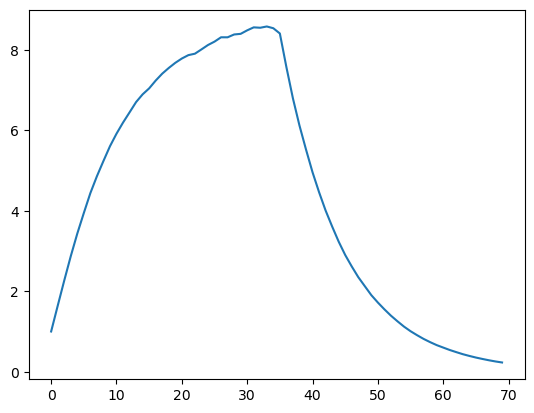

In [6]:
plt.plot(np.arange(par.T),np.mean(model.sim.k[:], axis=0))


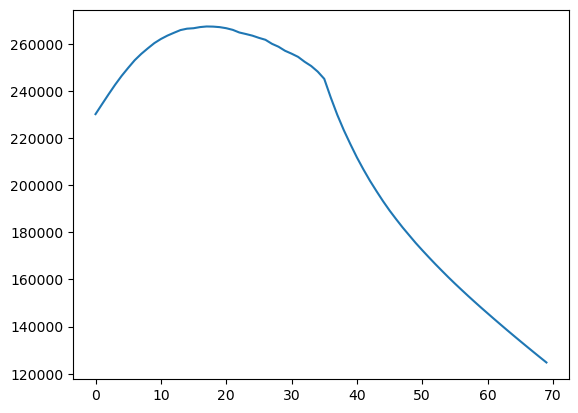

In [7]:
plt.plot(np.arange(par.T),np.mean(model.sim.w[:], axis=0))


In [8]:
model.sim.w[:, 0]

array([229848.19021534, 229261.76415928, 231205.80536663, 229848.19021534,
       231205.80536663, 230489.0366422 , 230489.0366422 , 229848.19021534,
       229261.76415928, 230489.0366422 , 230489.0366422 , 229848.19021534,
       231205.80536663, 230489.0366422 , 230489.0366422 , 231205.80536663,
       230489.0366422 , 229261.76415928, 229848.19021534, 230489.0366422 ,
       229848.19021534, 229848.19021534, 230489.0366422 , 231205.80536663,
       229848.19021534, 230489.0366422 , 229261.76415928, 231205.80536663,
       230489.0366422 , 229848.19021534, 230489.0366422 , 230489.0366422 ,
       230489.0366422 , 230489.0366422 , 230489.0366422 , 230489.0366422 ,
       232030.80785462, 231205.80536663, 230489.0366422 , 230489.0366422 ,
       230489.0366422 , 230489.0366422 , 231205.80536663, 230489.0366422 ,
       230489.0366422 , 231205.80536663, 229848.19021534, 229848.19021534,
       230489.0366422 , 230489.0366422 , 230489.0366422 , 229848.19021534,
       230489.0366422 , 2

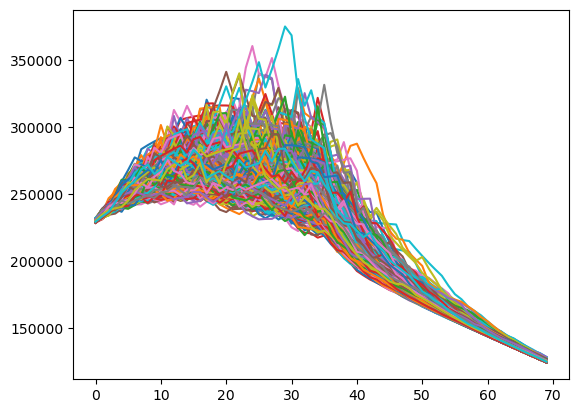

In [9]:
plt.plot(np.arange(par.T),model.sim.w[:].T)

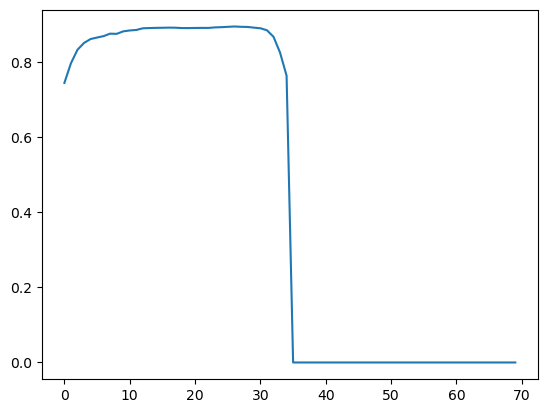

In [10]:
plt.plot(np.arange(par.T),np.mean(model.sim.h[:], axis=0))


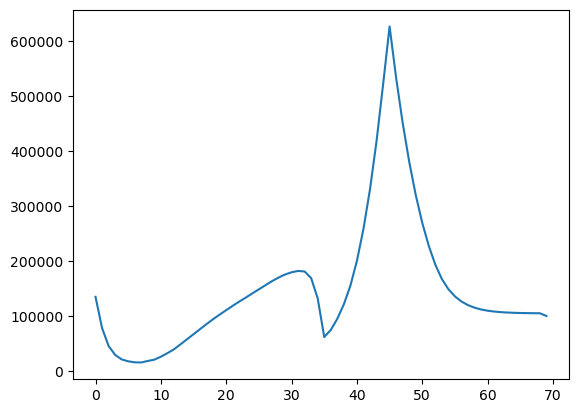

In [11]:
plt.plot(np.arange(par.T),np.mean(model.sim.a[:], axis=0))


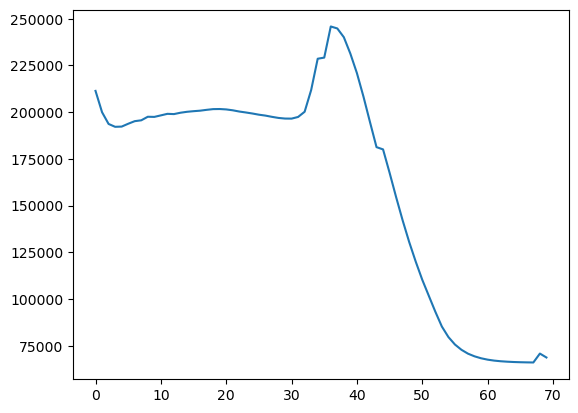

In [12]:
plt.plot(np.arange(par.T),np.mean(model.sim.c[:], axis=0))


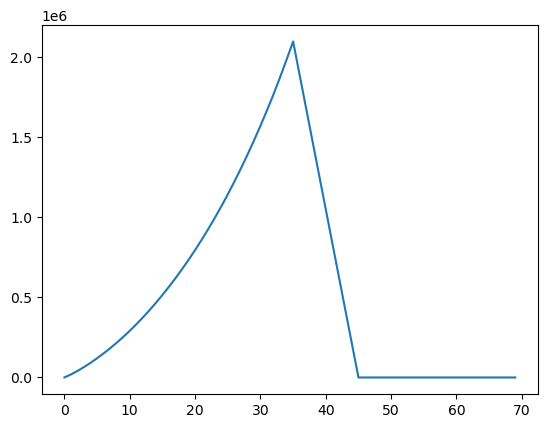

In [13]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


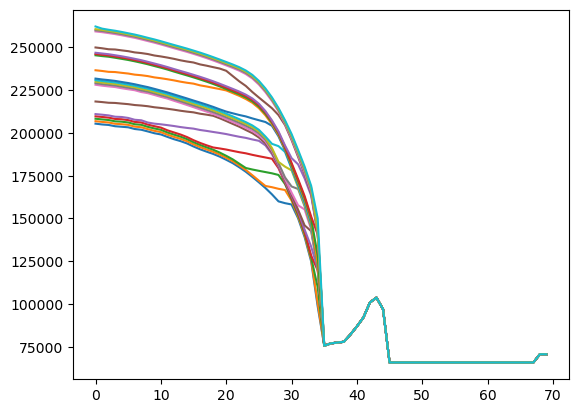

In [14]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [15]:
sol.V

array([[[[-353.27889816, -353.23472449, -353.19052077, ...,
          -352.32356553, -352.24401707, -352.16202549],
         [-353.21506488, -353.17093573, -353.12677796, ...,
          -352.26092458, -352.18145809, -352.09956615],
         [-353.1544485 , -353.11033882, -353.06620112, ...,
          -352.20083544, -352.12140607, -352.0395588 ],
         ...,
         [-352.27242526, -352.2283242 , -352.18419539, ...,
          -351.31904983, -351.23963775, -351.157811  ],
         [-352.21366871, -352.16956765, -352.12543885, ...,
          -351.26029328, -351.18088121, -351.09905445],
         [-352.15491217, -352.11081111, -352.0666823 , ...,
          -351.20153674, -351.12212466, -351.04029791]],

        [[-352.89025324, -352.85584026, -352.8197905 , ...,
          -352.02902461, -351.95316414, -351.87440487],
         [-352.82622287, -352.79185188, -352.75584651, ...,
          -351.96624716, -351.89047148, -351.81180274],
         [-352.7655196 , -352.73116695, -352.69518098, .

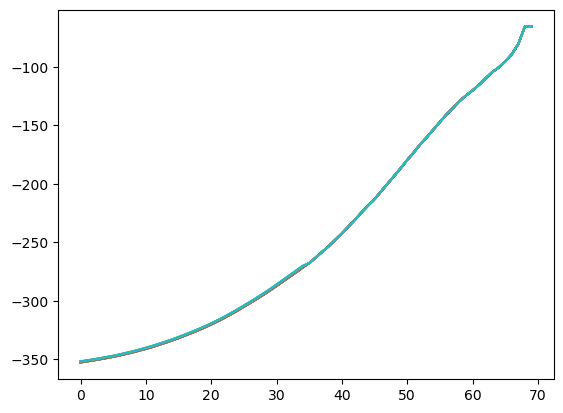

In [16]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.V[:, 1, 1, i])


In [17]:
sol.V[:, 4, 4, :]

array([[-351.63643368, -351.612141  , -351.58720353, ..., -350.96181621,
        -350.89916263, -350.83278815],
       [-350.75828213, -350.73397904, -350.70902377, ..., -350.08228878,
        -350.01949943, -349.95298528],
       [-349.88103328, -349.85670129, -349.83169882, ..., -349.20349727,
        -349.14050154, -349.07373489],
       ...,
       [ -78.45755882,  -78.45755882,  -78.45755882, ...,  -78.45755882,
         -78.45755882,  -78.45755882],
       [ -63.68960564,  -63.68960564,  -63.68960564, ...,  -63.68960564,
         -63.68960564,  -63.68960564],
       [ -63.6896057 ,  -63.6896057 ,  -63.6896057 , ...,  -63.6896057 ,
         -63.6896057 ,  -63.6896057 ]])

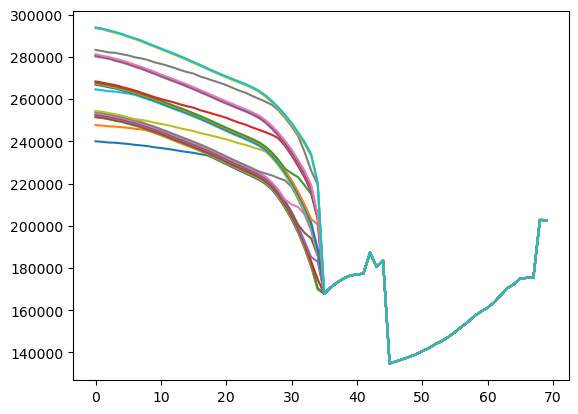

In [18]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 4, 4, i])

In [19]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

array([-8.78231382e-01, -8.77446574e-01, -9.68674901e-01, -1.05892665e+00,
       -1.04569348e+00, -1.20257681e+00, -1.33400779e+00, -1.28394668e+00,
       -1.54216995e+00, -1.52946054e+00, -1.63483815e+00, -1.83111119e+00,
       -1.81825744e+00, -1.94746596e+00, -2.07550947e+00, -2.20785341e+00,
       -2.23733800e+00, -2.32131328e+00, -2.44825572e+00, -2.63218716e+00,
       -2.77270734e+00, -2.91189532e+00, -3.13734673e+00, -3.17366794e+00,
       -3.43099807e+00, -3.38642685e+00, -3.53270661e+00, -3.60094643e+00,
       -3.69664044e+00, -3.98076147e+00, -3.97245527e+00, -4.06906287e+00,
       -4.05514869e+00, -4.24282084e+00, -4.29937997e+00, -4.66196582e+00,
       -4.88559954e+00, -4.84420280e+00, -5.35725419e+00, -5.44222927e+00,
       -5.84762535e+00, -5.85026052e+00, -6.20650999e+00, -5.88221194e+00,
       -4.39604115e+00, -6.68629926e+00, -6.57658162e+00, -6.58952835e+00,
       -6.60942084e+00, -6.96332623e+00, -6.53376810e+00, -6.95451447e+00,
       -6.05425145e+00, -

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\B465929\AppData\Local\Temp\ipykernel_15508\2554536382.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')
C:\Users\B465929\AppData\Local\Temp\ipykernel_15508\2554536382.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')


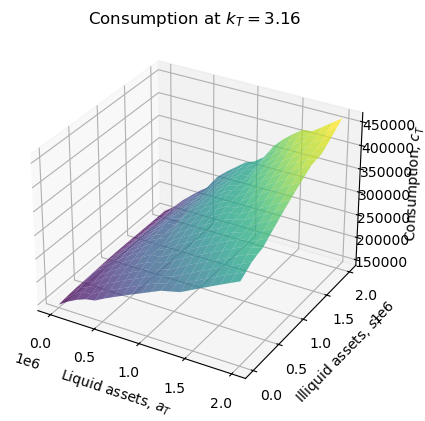

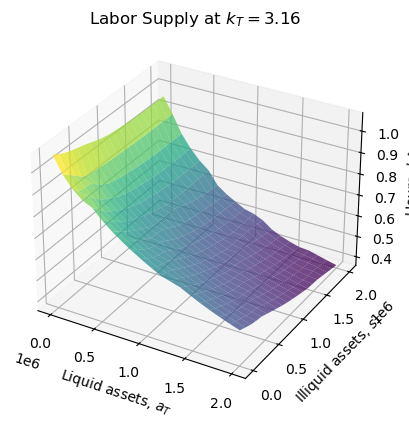

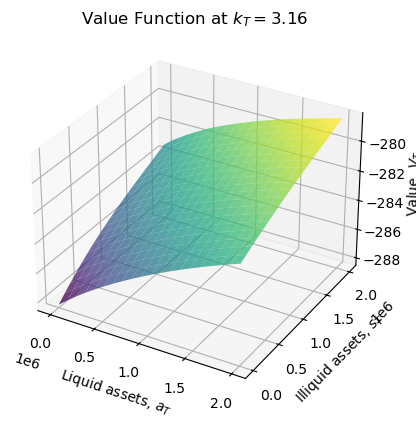

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
